# TUTORIAL- InterfaceGAN

Let's walk through how to use InterfaceGAN to perform Style Editing on any GAN model. This is a companion notebook to the online text of Chapter 2:

https://wlg1.github.io/ch2.1.html

# Load Model

In [ ]:
%%capture
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch

!pip install ninja

import os
import re

import dnnlib
import numpy as np
import PIL.Image
import torch

import legacy

We'll load our furry model that has been fine-tuned on anime faces via transfer learning. However, any GAN can be used.

In [ ]:
%cd /content/
!gdown 10GbfW9wPJCdmQO-y8ttteG7SQuS_s5bE

%cd stylegan2-ada-pytorch
network_pkl = '/content/network-snapshot-000006.pkl'
device = torch.device('cuda') # we will use a GPU
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

/content
Downloading...
From: https://drive.google.com/uc?id=10GbfW9wPJCdmQO-y8ttteG7SQuS_s5bE
To: /content/network-snapshot-000006.pkl
100% 364M/364M [00:03<00:00, 96.5MB/s]
/content/stylegan2-ada-pytorch


# Style Editing

Now let's edit the image using InterFaceGAN. We'll be finding out how to use the code from the official repository to run InterFaceGAN on any neural network. In Chapter 2, Style Editing was performed by the following equation:

$$ z + \alpha * c_n $$

Where z is a latent code input, and $c_n$ is the feature vector $n$ we want to change that has been conditioned on the other features we don't want to change while changing $n$.


In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'interfacegan'
!git clone https://github.com/genforce/interfacegan.git $CODE_DIR

Cloning into 'interfacegan'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 613 (delta 94), reused 92 (delta 92), pack-reused 489
Receiving objects: 100% (613/613), 13.72 MiB | 2.45 MiB/s, done.
Resolving deltas: 100% (204/204), done.


First, let's get our input vector $z$.

In [ ]:
seed = 20
z = np.random.RandomState(seed).randn(1, G.z_dim) 
z = torch.from_numpy(z).to(device)

Let's see what the output of z is when put through our model.

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


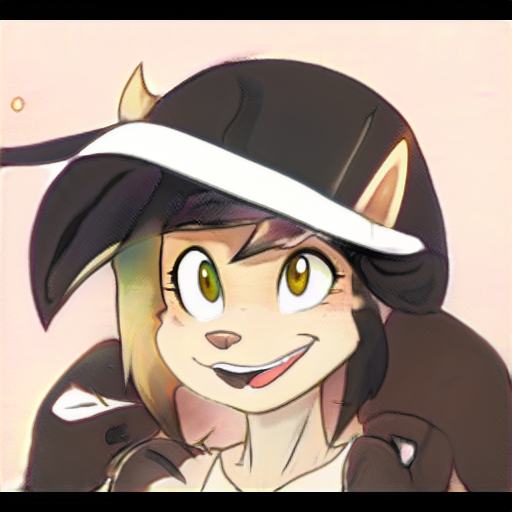

In [ ]:
truncation_psi = 0.7
noise_mode = 'const' # 'const', 'random', 'none'
outdir = '/content/output/'

os.makedirs(outdir, exist_ok=True)
label = torch.zeros([1, G.c_dim], device=device)
img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
# PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

Second, we'll get $c_n$, the pre-trained hyperplane boundaries. The pre-trained hyperplane boundaries we'll first be loading will depend on whether we're using StyleGAN and its W latent space, or not. For now, let's assume we are.

In [ ]:
model_name = "stylegan_ffhq"
latent_space_type = 'W'

ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
boundaries = {}
for i, attr_name in enumerate(ATTRS):
    boundary_name = f'{model_name}_{attr_name}'
    if 'stylegan' in model_name and latent_space_type == 'W':
        boundaries[attr_name] = np.load(f'/content/interfacegan/boundaries/{boundary_name}_w_boundary.npy')
    else:
        boundaries[attr_name] = np.load(f'/content/interfacegan/boundaries/{boundary_name}_boundary.npy')

In [ ]:
boundaries['age'].shape

(1, 512)

These boundaries are a 512-dim vector, with the same dimensions as a latent code input. This is because they contain the coefficients that define the vector that is being changed. 



---


Next, we'll need to convert this numpy array into a pytorch tensor, as stated here:

https://stackoverflow.com/questions/49768306/pytorch-tensor-to-numpy-array

In [ ]:
new_codes = z.cpu().detach().numpy()
new_codes.shape

(1, 512)

Finally, we'll use sliders to set the values of $\alpha$ for each of the features we'll be changing, and we'll use all our terms to calculate $z + \alpha * c_n$.

In [ ]:
age = 3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = 2.9 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = -3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = -1.1 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = 1.1 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)


To put our new input through the model, we'll need to convert it to a PyTorch tensor. Let's compare our old output and new output side by side.

In [ ]:
new_z = torch.from_numpy(new_codes).to(device)

new_img = G(new_z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
new_img_2 = (new_img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)

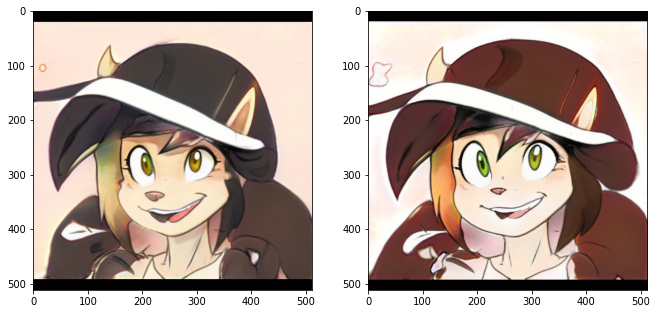

In [ ]:
# https://stackoverflow.com/questions/50559000/how-do-i-make-2-images-appear-side-by-side-in-jupyter-notebook-ipython

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = img.cpu().detach().numpy()
img_B = new_img_2.cpu().detach().numpy()

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A[0])
ax[1].imshow(img_B[0])

## Interpolation between the original and the edit

We can also make an interpolation video between our old and new sample:

In [ ]:
from IPython import display as ipythondisplay
import io
import imageio
import os
import base64
from IPython.display import HTML

def lerp(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            t = index/float(steps)
            out.append(zs[i+1]*t + zs[i]*(1-t))
    return out

def show_video(vid):
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))
  

In [ ]:
zs = [z, new_z]

ws = []
for z_idx, z in enumerate(zs):
    w = G.mapping(z, label, truncation_psi=truncation_psi, truncation_cutoff=8)
    ws.append(w)

In [ ]:
frame_ws = lerp(ws, 100)

outdir = '/content/output-frames-w/'
os.makedirs(outdir, exist_ok=True)

for idx, w in enumerate(frame_ws): 
    img = G.synthesis(w, noise_mode=noise_mode, force_fp32=True)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/frame-{idx:04d}.png')

In [ ]:
!ffmpeg -i /content/output-frames-w/frame-%04d.png -r 24 -vcodec libx264 -pix_fmt yuv420p /content/lerp-w.mp4

In [ ]:
%mkdir out
movieName = '/content/lerp-w.mp4'
# with imageio.get_writer(movieName, mode='I') as writer:
#     for image in log_progress(list(imgs), name = "Creating animation"):
#         writer.append_data(np.array(image))
show_video(movieName)

# Training new feature boundaries using SVMs

Note that this new output was not changed by the features we set on the slider. This is because the boundaries used by stylegan_ffhq are not applicable to this GAN; thus, we need to calculate them again for this model. The code for doing so is found here:

https://github.com/genforce/interfacegan/blob/master/train_boundary.py